# Hi all. 🙋

#### Today, we are going to continue our Machine Learning series with Gender Classification Dataset.

In this notebook we will implement new beginner friendly end to end ML model by using **CATBOOST** with **Optuna HyperParameter Tuning**.

**Context**

Gender is a social construct. The way males and females are treated differently since birth moulds their behaviour and personal preferences into what society expects for their gender.


This small dataset is designed to provide an idea about whether a person's gender can be predicted with an accuracy significantly above 50% based on their personal preferences.

**Content**

The data was collected in Fall 2015 from university students of 21 nationalities studying various majors in various countries using this form:

https://docs.google.com/forms/d/e/1FAIpQLSduEjDURjTh7-a1ZjjlIYx75ScVETLp_gmoFszypz2J7E0LtQ/viewform

The responses were then pre-processed and grouped into categories in order to obtain the final, transformed dataset.

**Inspiration**

With the rise of feminism, the difference between males and females in terms of their personal preferences has decreased in recent years. For instance, historically in many cultures, warm colors such as red and pink were thought of as feminine colors while cool colors such as blue were considered masculine. Today, such ideas are considered outdated.

Despite the decrease in the influence of gender on people’s personal preferences, can a decent gender classifier be built given a dataset with people’s personal preferences? What does this small dataset suggest?

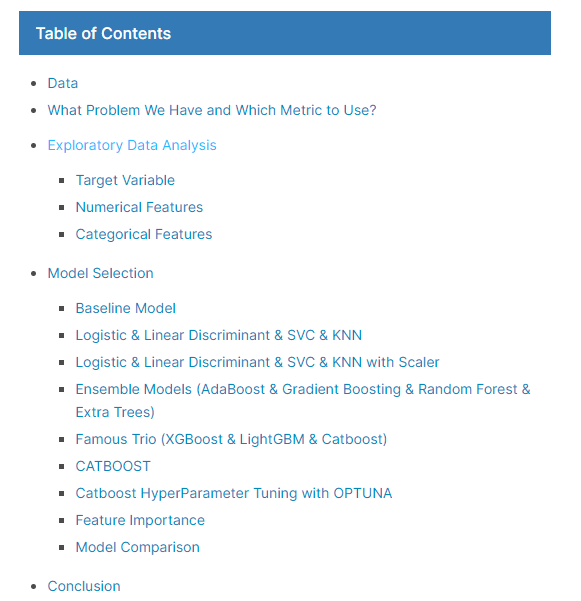

# DATA

Our dataset consists of the following columns:
    
- **Favorite Color**: Favorite color (colors reported by respondents were mapped to either warm, cool or neutral)
- **Favorite Music Genre**: Favorite broad music genre    
- **Favorite Beverage**: Favorite alcoholic drink
- **Favorite Soft Drink**: Favorite fizzy drink
- **Gender**: Binary gender as reported by the respondents 

# What Problem We Have and Which Metric to Use?


- Based on the data and data dictionary, we have a classification problem.
- We wil make classification on the target variable **Gender**.
- And we will build a model to get best calssification possible on the target variable.
- For that we will look at the balance of the target variable.
- As we will see later, our target variable has balanced or balanced like data.
- Therefore, we will use **Accuracy** score to evaluate our model.

# Exploratory Data Analysis

First thing first, let's import the libraries that we will use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")


pd.set_option('max_columns',100)
pd.set_option('max_rows',900)
pd.set_option('max_colwidth',200)

In [2]:
data = pd.read_csv("../input/gender-classification/Transformed Data Set - Sheet1.csv")
data.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


In [3]:
data_1 = data.copy()

In [4]:
data_1["Gender"] = data_1["Gender"].map(lambda x: 0 if x=="F" else 1)

In [5]:
df = data_1.copy()

In [6]:
df.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,0
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,0
2,Warm,Rock,Wine,Coca Cola/Pepsi,0
3,Warm,Folk/Traditional,Whiskey,Fanta,0
4,Cool,Rock,Vodka,Coca Cola/Pepsi,0


In [7]:
df.shape

(66, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Favorite Color        66 non-null     object
 1   Favorite Music Genre  66 non-null     object
 2   Favorite Beverage     66 non-null     object
 3   Favorite Soft Drink   66 non-null     object
 4   Gender                66 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 2.7+ KB


- We have 66 rows and 5 columns. 
- All columns are object.
- We have no missing value.

In [9]:
df.duplicated().sum()

4

- We hav 4 duplicated rows. We will drop those later on.

In [10]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
Favorite Color,0,0.0
Favorite Music Genre,0,0.0
Favorite Beverage,0,0.0
Favorite Soft Drink,0,0.0
Gender,0,0.0


In [11]:
numerical= df.drop(['Gender'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index([], dtype='object')


Categorical Columns: Index(['Favorite Color', 'Favorite Music Genre', 'Favorite Beverage',
       'Favorite Soft Drink'],
      dtype='object')


In [12]:
df[categorical].nunique()

Favorite Color          3
Favorite Music Genre    7
Favorite Beverage       6
Favorite Soft Drink     4
dtype: int64

- So far so good. No zero variance and no extremely high variance.

### Target Variable

In [13]:
y = df['Gender']
print(f'Percentage of female respondents:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} patient)\nPercentage of male respondents: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} patient)')

Percentage of female respondents:  50.0 %  --> (33 patient)
Percentage of male respondents: 50.0  %  --> (33 patient)


- We have perfectly balanced data in terms of our label feature.
- We can use 'accuracy' metric as our evaluation metric.

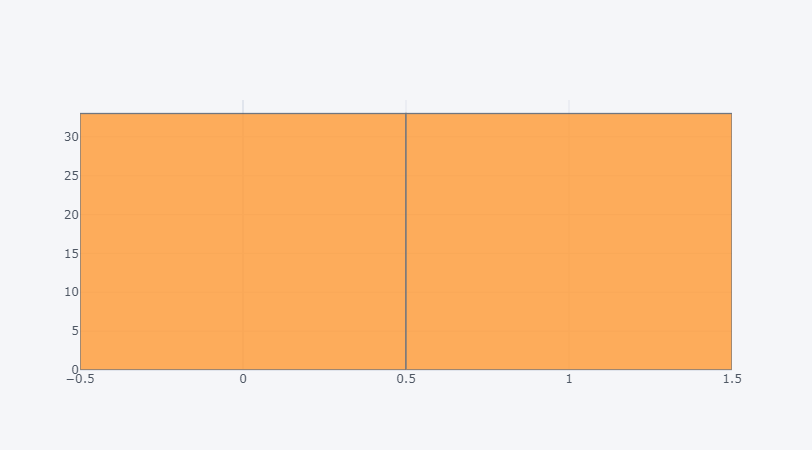

In [14]:
df.Gender.iplot(kind="hist");

### Numerical Features

- We have no numerical feature in our dataset.

### Categorical Features

In [15]:
df[categorical].head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink
0,Cool,Rock,Vodka,7UP/Sprite
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi
2,Warm,Rock,Wine,Coca Cola/Pepsi
3,Warm,Folk/Traditional,Whiskey,Fanta
4,Cool,Rock,Vodka,Coca Cola/Pepsi


**Favorite Color vs. Gender**

In [16]:
df["Favorite Color"].unique()

array(['Cool', 'Neutral', 'Warm'], dtype=object)

In [17]:
df[df["Favorite Color"] == "Cool"]["Gender"].value_counts(normalize=True)

1    0.540541
0    0.459459
Name: Gender, dtype: float64

In [18]:
df[df["Favorite Color"] == "Cool"]["Gender"].value_counts()

1    20
0    17
Name: Gender, dtype: int64

In [19]:
df[df["Favorite Color"] == "Neutral"]["Gender"].value_counts(normalize=True)

1    0.571429
0    0.428571
Name: Gender, dtype: float64

In [20]:
df[df["Favorite Color"] == "Neutral"]["Gender"].value_counts()

1    4
0    3
Name: Gender, dtype: int64

In [21]:
df[df["Favorite Color"] == "Warm"]["Gender"].value_counts(normalize=True)

0    0.590909
1    0.409091
Name: Gender, dtype: float64

In [22]:
df[df["Favorite Color"] == "Warm"]["Gender"].value_counts()

0    13
1     9
Name: Gender, dtype: int64

In [23]:
print (f'A respondent, whose favorite color is cool, has a probability of {round(df[df["Favorite Color"]=="Cool"]["Gender"].value_counts(normalize=True)[0], 2)} of being female and {round(df[df["Favorite Color"]=="Cool"]["Gender"].value_counts(normalize=True)[1], 2)} of being male.')

print()

print (f'A respondent, whose favorite color is neutral, has a probability of {round(df[df["Favorite Color"]=="Neutral"]["Gender"].value_counts(normalize=True)[0], 2)} of being female and {round(df[df["Favorite Color"]=="Neutral"]["Gender"].value_counts(normalize=True)[1], 2)} of being male.')

print()

print (f'A respondent, whose favorite color is warm, has a probability of {round(df[df["Favorite Color"]=="Warm"]["Gender"].value_counts(normalize=True)[0], 2)} of being female and {round(df[df["Favorite Color"]=="Warm"]["Gender"].value_counts(normalize=True)[1], 2)} of being male.')

A respondent, whose favorite color is cool, has a probability of 0.46 of being female and 0.54 of being male.

A respondent, whose favorite color is neutral, has a probability of 0.43 of being female and 0.57 of being male.

A respondent, whose favorite color is warm, has a probability of 0.59 of being female and 0.41 of being male.


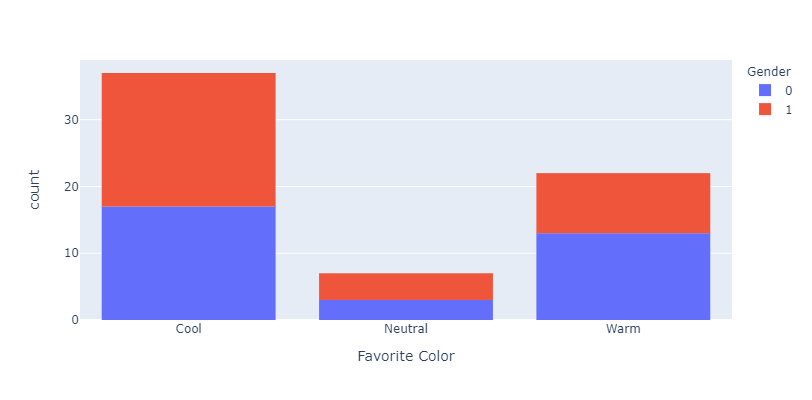

In [24]:
fig = px.histogram(data_frame=df, x="Favorite Color", color="Gender", width=400, height=400)
fig.show()

- While men prefer cool and neutral colors,
- women prefer warm colors.

**Favorite Music Genre vs. Gender**

In [25]:
df["Favorite Music Genre"].unique()

array(['Rock', 'Hip hop', 'Folk/Traditional', 'Jazz/Blues', 'Pop',
       'Electronic', 'R&B and soul'], dtype=object)

In [26]:
round(df.groupby("Favorite Music Genre")["Gender"].mean(), 2).sort_values(ascending=False)

Favorite Music Genre
Hip hop             0.88
Electronic          0.75
R&B and soul        0.67
Folk/Traditional    0.50
Rock                0.47
Jazz/Blues          0.25
Pop                 0.24
Name: Gender, dtype: float64

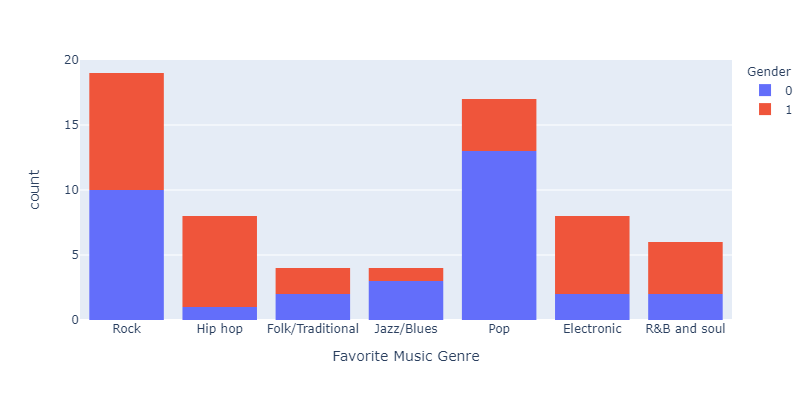

In [27]:
fig = px.histogram(data_frame=df, x="Favorite Music Genre", color="Gender", width=400, height=400)
fig.show()

- Number of men and women, whose favorite music genre is Rock, is almost equal.
- For other music genres, number of genders differs significantly form each other.

**Favorite Beverage vs. Gender**

In [28]:
df["Favorite Beverage"].unique()

array(['Vodka', 'Wine', 'Whiskey', "Doesn't drink", 'Beer', 'Other'],
      dtype=object)

In [29]:
round(df.groupby("Favorite Beverage")["Gender"].mean(), 2).sort_values(ascending=False)

Favorite Beverage
Doesn't drink    0.64
Vodka            0.56
Beer             0.54
Whiskey          0.44
Wine             0.40
Other            0.36
Name: Gender, dtype: float64

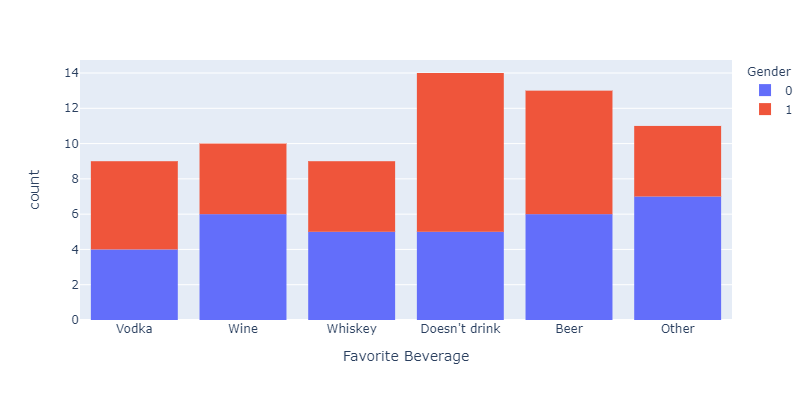

In [30]:
fig = px.histogram(data_frame=df, x="Favorite Beverage", color="Gender", width=400, height=400)
fig.show()

- While 28 of female respondents drink alcohol, 5 of them do not drink any type of alcohol.
- While 24 of male respondents drink alcohol, 9 of them do not drink any type of alcohol.

**Favorite Soft Drink vs. Gender**

In [31]:
df["Favorite Soft Drink"].unique()

array(['7UP/Sprite', 'Coca Cola/Pepsi', 'Fanta', 'Other'], dtype=object)

In [32]:
round(df.groupby("Favorite Soft Drink")["Gender"].mean(), 2).sort_values(ascending=False)

Favorite Soft Drink
Other              0.71
Fanta              0.57
Coca Cola/Pepsi    0.47
7UP/Sprite         0.38
Name: Gender, dtype: float64

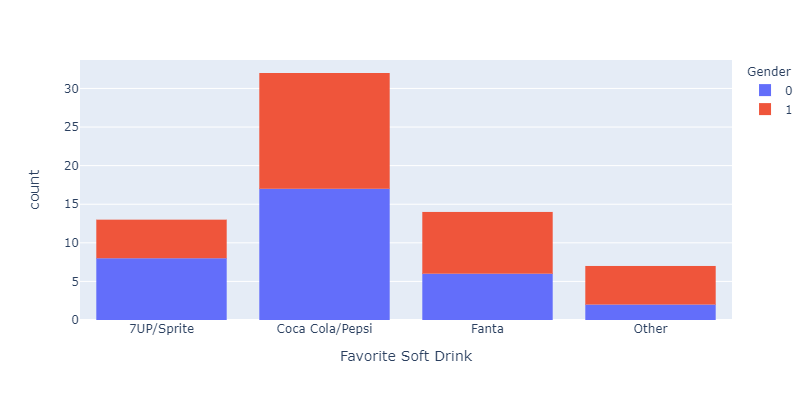

In [33]:
fig = px.histogram(data_frame=df, x="Favorite Soft Drink", color="Gender", width=400, height=400)
fig.show()

- Majority of female respondents prefer Coca Cola/Pepsi.
- Majority of male respondents prefer soft drinks other than Coca Cola/Pepsi.

**Overall Insights from the Exploratory Data Analysis**

- Target variable has perfect balanced data.
- There is no numeric feature.
- While men prefer cool and neutral colors,
- women prefer warm colors.
- Number of men and women, whose favorite music genre is Rock, is almost equal.
- For other music genres, number of genders differs significantly form each other.
- While 28 of female respondents drink alcohol, 5 of them do not drink any type of alcohol.
- While 24 of male respondents drink alcohol, 9 of them do not drink any type of alcohol.
- Majority of female respondents prefer Coca Cola/Pepsi.
- Majority of male respondents prefer soft drinks other than Coca Cola/Pepsi.

# MODEL SELECTION

- We'll use dummy classifier model as a base model.
- And then we will use Logistic & Linear Discriminant & KNeighbors, and Support Vector Machine models with and without scaler.
- And then we will use ensemble models (Adaboost, Randomforest, Gradient Boosting, and Extra Trees).
- We will see famous trio: XGBoost,LightGBM & Catboost.
- Finally, we will look in detail to hyperparameter tuning for Catboost.

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

from sklearn.pipeline import make_pipeline

**Baseline Modle**

In [35]:
accuracy =[]
model_names =[]


X= df.drop('Gender', axis=1)
y= df['Gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  


model = DummyClassifier(strategy='constant', constant=1)
pipe = make_pipeline(ct, model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['DummyClassifier']
dummy_result_df = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
dummy_result_df

model : DummyClassifier(constant=1, strategy='constant') and  accuracy score is : 0.45


,Accuracy
DummyClassifier,0.45


- With **DummyClassifier** we had quite bad accuracy score.

**Logistic & Linear Discriminant & SVC & KNN**

In [36]:
accuracy =[]
model_names =[]


X= df.drop('Gender', axis=1)
y= df['Gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  


lr = LogisticRegression(solver='liblinear')
# lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,svm,knn]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic','SVM','KNeighbors']
result_df1 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df1

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.35
model : SVC() and  accuracy score is : 0.5
model : KNeighborsClassifier() and  accuracy score is : 0.3


,Accuracy
Logistic,0.35
SVM,0.50
KNeighbors,0.30


In [37]:
accuracy =[]
model_names =[]


X= df.drop('Gender', axis=1)
y= df['Gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
s= StandardScaler()
ct1= make_column_transformer((ohe,categorical),(s,numerical))  


lr = LogisticRegression(solver='liblinear')
# lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,svm,knn]

for model in models: 
    pipe = make_pipeline(ct1, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic_scl','SVM_scl','KNeighbors_scl']
result_df2 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df2

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.35
model : SVC() and  accuracy score is : 0.5
model : KNeighborsClassifier() and  accuracy score is : 0.3


,Accuracy
Logistic_scl,0.35
SVM_scl,0.50
KNeighbors_scl,0.30


- Let's see how ensemble models do with the problem at hand.

**Ensemble Models (AdaBoost & Gradient Boosting & Random Forest & Extra Trees)**

In [38]:
accuracy =[]
model_names =[]


X= df.drop('Gender', axis=1)
y= df['Gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  

ada = AdaBoostClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
et=  ExtraTreesClassifier(random_state=0)



models = [ada,gb,rf,et]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Ada','Gradient','Random','ExtraTree']
result_df3 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df3

model : AdaBoostClassifier(random_state=0) and  accuracy score is : 0.35
model : GradientBoostingClassifier(random_state=0) and  accuracy score is : 0.5
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.45
model : ExtraTreesClassifier(random_state=0) and  accuracy score is : 0.55


,Accuracy
Ada,0.35
Gradient,0.50
Random,0.45
ExtraTree,0.55


- OK. Let's see the very famous trio:

XGBoost,
Light GBM,
Catboost

**Famous Trio (XGBoost & LightGBM & Catboost)**

- I'll use Catboost alone by using its capability to handle categorical variables without doing any preprocessing.

- Let's first look at the XGBoost and LightGBM

In [39]:
accuracy =[]
model_names =[]


X= df.drop('Gender', axis=1)
y= df['Gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  

xgbc = XGBClassifier(random_state=0)
lgbmc=LGBMClassifier(random_state=0)


models = [xgbc,lgbmc]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['XGBoost','LightGBM']
result_df4 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df4

[22:32:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Accuracy
XGBoost,0.35
LightGBM,0.50


- Now let's see Catboost

**CATBOOST**

**Purpose**:

Training and applying models for the classification problems. Provides compatibility with the scikit-learn tools.

**The default optimized objective depends on various conditions**:

**Logloss** — The target has only two different values or the target_border parameter is not None.

**MultiClass** — The target has more than two different values and the border_count parameter is None.

In [40]:
accuracy =[]
model_names =[]


X= df.drop('Gender', axis=1)
y= df['Gender']
categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False,random_state=0)

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df5 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df5

,Accuracy
Catboost_default,0.5


- Let's make some adjustment on the Catboost model to see its' peak performance on the problem.

**Catboost HyperParameter Tuning with Optuna**

In [41]:
def objective(trial):
    X= df.drop('Gender', axis=1)
    y= df['Gender']
    categorical_features_indices = np.where(X.dtypes != np.float)[0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.5, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-10-19 22:32:31,285] A new study created in memory with name: no-name-994b9e69-1790-4d91-ba86-26bcfa65152f
[I 2021-10-19 22:32:31,398] Trial 0 finished with value: 0.45 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.03750120166683407, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.45.
[I 2021-10-19 22:32:31,515] Trial 1 finished with value: 0.45 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.035861550350882156, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5867176564284899}. Best is trial 0 with value: 0.45.
[I 2021-10-19 22:32:31,601] Trial 2 finished with value: 0.45 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05267644591658632, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.080762190455019}. Best is trial 0 with value: 0.45.
[I 2021-10-19 22:32:31,684] Trial 3 finished with value: 0.45

Number of finished trials: 50
Best trial:
  Value: 0.6
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.062279168592783485
    depth: 5
    boosting_type: Ordered
    bootstrap_type: MVS


**Parameters**:

- **Objective**: Supported metrics for overfitting detection and best model selection

- **colsample_bylevel**: this parameter speeds up the training and usually does not affect the quality.

- **depht**: Depth of the tree.

- **boosting_type**: By default, the boosting type is set to for small datasets. This prevents overfitting but it is expensive in terms of computation. Try to set the value of this parameter to to speed up the training.

- **bootstrap_type**: By default, the method for sampling the weights of objects is set to . The training is performed faster if the method is set and the value for the sample rate for bagging is smaller than 1.

Reference: https://catboost.ai/



- Ok let's use our best model with new parameters.

In [42]:
accuracy =[]
model_names =[]


X= df.drop('Gender', axis=1)
y= df['Gender']
categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False,random_state=0,
                          objective= 'CrossEntropy',
    colsample_bylevel= 0.04292240490294766,
    depth= 10,
    boosting_type= 'Plain',
    bootstrap_type= 'MVS')

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df6

              precision    recall  f1-score   support

           0       0.50      0.09      0.15        11
           1       0.44      0.89      0.59         9

    accuracy                           0.45        20
   macro avg       0.47      0.49      0.37        20
weighted avg       0.47      0.45      0.35        20



,Accuracy
Catboost_tuned,0.45


 # Feature Importance

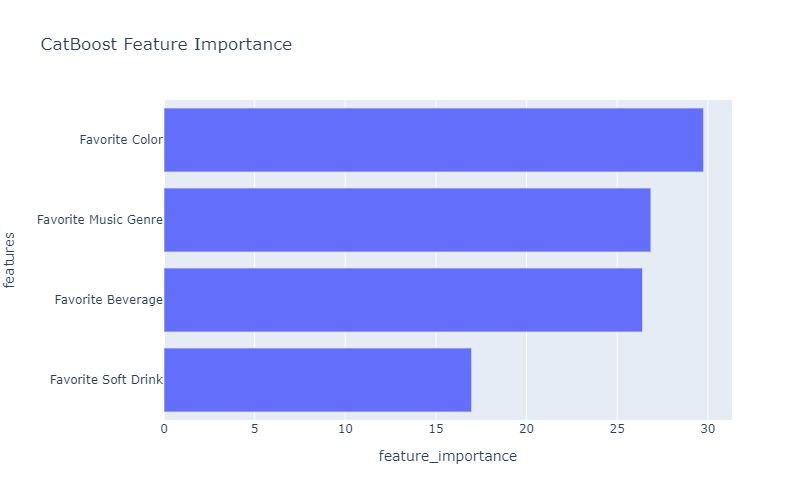

In [43]:
feature_importance = np.array(model.get_feature_importance())
features = np.array(X_train.columns)
fi={'features':features,'feature_importance':feature_importance}
df_fi = pd.DataFrame(fi)
df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)
fig = px.bar(df_fi, x='feature_importance', y='features',title="CatBoost Feature Importance",height=500)
fig.show()

In [44]:
result_final = pd.concat([dummy_result_df,result_df1,result_df2,result_df3,result_df4,result_df5,result_df6],axis=0)
result_final

,Accuracy
DummyClassifier,0.45
Logistic,0.35
SVM,0.50
KNeighbors,0.30
Logistic_scl,0.35
SVM_scl,0.50
KNeighbors_scl,0.30
Ada,0.35
Gradient,0.50
Random,0.45


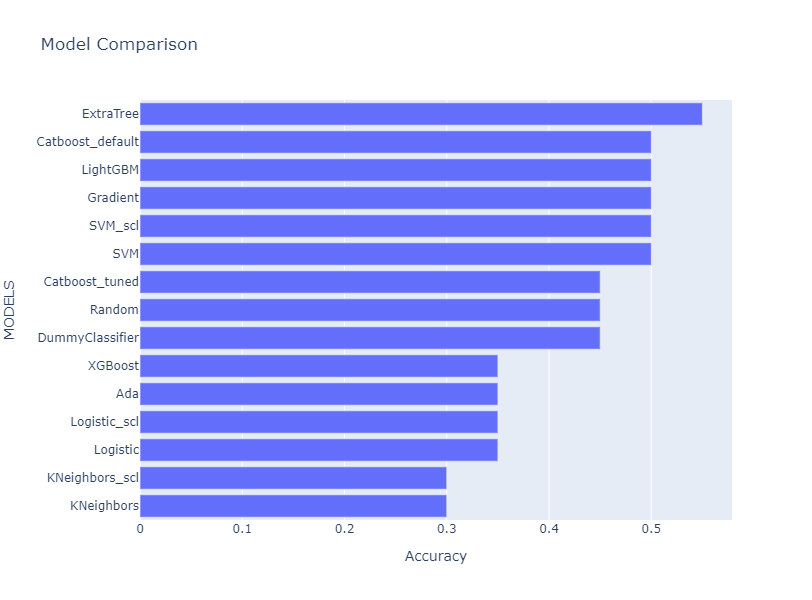

In [45]:
result_final.sort_values(by=['Accuracy'], ascending=True,inplace=True)
fig = px.bar(result_final, x='Accuracy', y=result_final.index,title='Model Comparison',height=600,labels={'index':'MODELS'})
fig.show()

# Conclusion 

- We have developed model to classifiy heart disease cases.

- First, we made the detailed exploratory analysis.

- We have decided which metric to use.
- We analyzed both target and features in detail.
- We transform categorical variables into numeric so we can use them in the model.
- We use pipeline to avoid data leakage.
- We looked at the results of the each model and selected the best one for the problem on hand.
- We looked in detail Catboost
- We made hyperparameter tuning of the Catboost with Optuna to see the improvement
- We looked at the feature importance.